In [1]:
import gym
import __init__
import time
import numpy as np
#0: up
#1: down
#2: left
#3: right
#4: nothing

#enter a number to select agent and move it with wasd

env = gym.make('pressureplate-custom-2p-4')
state = env.reset()
env.render()
agent = 0
dones = [False, False]
stop = False
for i in range(1000):
    if stop:
        break
    action = [4,4]
    _input = input("Enter action as wasd or number to change agent:")

    if _input in ["0","1"]:
        agent = int(_input)
        continue
    elif _input in ["w", "a", "s", "d"]:
        if _input == "w":
            action[agent] = 0
        elif _input == "a":
            action[agent] = 2
        elif _input == "d":
            action[agent] = 3
        else:
            action[agent] = 1
    else:
        continue
    
    if all(dones):
        stop = True
    next_state, reward, dones, _ =  env.step(action)
    env.render()
    print(i,"-----------------")
    print(dones)
    print(reward)
    
    print("------------------------")

/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-linear-1p-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-custom-2p-0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-custom-2p-1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-custom-2p-2 already in registry.
  logger.warn(f"Overriding environm

In [2]:
from MADDPGV2.maddpg import MADDPG
from MADDPGV2 import gradient_estimators
from MADDPGV2.buffer import ReplayBuffer
import torch
import numpy as np
import gym
import __init__
import time
from time import sleep, time
import random
from matplotlib import pyplot as plt


env = gym.make('pressureplate-custom-2p-0')
obs_dim = env.observation_space

gradient_estimator = gradient_estimators.GST()

maddpg = MADDPG(
        env=env,
        critic_lr=2e-4,
        actor_lr=2e-4,
        gradient_clip=1.0,
        hidden_dim_width=256,
        gamma=0.96,
        soft_update_size=0.01,
        policy_regulariser=0.001,
        gradient_estimator= gradient_estimator,
        standardise_rewards=True
    )



#maddpg = torch.load("trained_agents/second_cp1_other.pt")


observation_dims = np.array([obs.shape[0] for obs in env.observation_space])


/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [28]:
import __init__
import gym

max_episode_length = 500
max_time_steps = 1_000_000
max_episode_num = max_time_steps // max_episode_length
episode_counter = 0


eval_freq = 20
epsilon = 1
def get_epsilon(epsilon_start = 1, epsilon_end = 0.1, current = 1, decay_period = int(max_time_steps * (8/10))):
    if current <= 0:
        return 0
    delta = (epsilon_start - epsilon_end) / decay_period
    return current - delta

buffer = ReplayBuffer(capacity = max_time_steps, obs_dims= observation_dims, batch_size = 1024)

def evaluate(maddpg, max_episode_length = 200):
    eval_env = gym.make('pressureplate-custom-2p-0')
    obs, _ = eval_env.reset()
    eval_reward = np.zeros((2,))
    for i in range(max_episode_length):
        acts = maddpg.acts(obs)
        nobs, rwds, dones, _ = eval_env.step(acts)
        obs = nobs
        eval_reward += np.array(rwds)
        if all(dones):
            break
    maddpg.evaluation_rewards_history.append(eval_reward)
        

modes = np.array([0,1,2,3,4])
mode_dist = np.array([5,3,2,1,1])
mode_dist = mode_dist / mode_dist.sum()
start_order = np.random.choice(modes, max_episode_num, p=mode_dist)



for mode in start_order:
    print(episode_counter,"/",len(start_order), "  mode:", mode)
    episode_counter += 1
    env = gym.make('pressureplate-custom-2p-{}'.format(mode))
    obs, _  = env.reset()
    dones = [False] * env.n_agents
    episode_steps = 0
    episode_return = np.zeros((env.n_agents,))
    stop = False

    if episode_counter % 20:
        evaluate(maddpg=maddpg)
        

    while not stop:    
        epsilon = get_epsilon(current = epsilon)

        explore = random.uniform(0,1)
        if explore < epsilon:
            acts = env.action_space.sample()
        else:
            acts = maddpg.acts(obs)
        if all(dones) or (episode_steps >= max_episode_length):
            if all(dones):
                print("Goal is reached!!")
            stop = True
        
        nobs, rwds, dones, _ = env.step(acts)
        episode_steps += 1
        episode_return += np.array(rwds)
        
        if buffer is not None:
                    buffer.store(
                        obs=obs,
                        acts=acts,
                        rwds=rwds,
                        nobs=nobs,
                        dones=dones,
                    )
        obs = nobs

        sample = buffer.sample()
        if sample is not None:
            maddpg.update(sample)

0 / 666   mode: 0


/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array 

1 / 666   mode: 2
2 / 666   mode: 1
3 / 666   mode: 0
4 / 666   mode: 3
5 / 666   mode: 4
6 / 666   mode: 1
7 / 666   mode: 2
8 / 666   mode: 3
9 / 666   mode: 2
10 / 666   mode: 0
11 / 666   mode: 1
12 / 666   mode: 1
13 / 666   mode: 2
14 / 666   mode: 0
15 / 666   mode: 0
16 / 666   mode: 1
17 / 666   mode: 2
18 / 666   mode: 0
19 / 666   mode: 0
20 / 666   mode: 1
21 / 666   mode: 0
22 / 666   mode: 1
23 / 666   mode: 0
24 / 666   mode: 0
25 / 666   mode: 2
26 / 666   mode: 2
27 / 666   mode: 1
28 / 666   mode: 2
29 / 666   mode: 3
30 / 666   mode: 1
31 / 666   mode: 2
32 / 666   mode: 0
33 / 666   mode: 2
34 / 666   mode: 1
35 / 666   mode: 2
36 / 666   mode: 2
37 / 666   mode: 0
38 / 666   mode: 1
39 / 666   mode: 1
40 / 666   mode: 2
41 / 666   mode: 1
42 / 666   mode: 0
43 / 666   mode: 0
44 / 666   mode: 2
45 / 666   mode: 1
46 / 666   mode: 2
47 / 666   mode: 1
48 / 666   mode: 2
49 / 666   mode: 0
50 / 666   mode: 3
51 / 666   mode: 0
52 / 666   mode: 0
53 / 666   mode: 0
54

In [16]:
torch.save(maddpg, "trained_agents/fourth_cp1.pt")

(1517, 2)


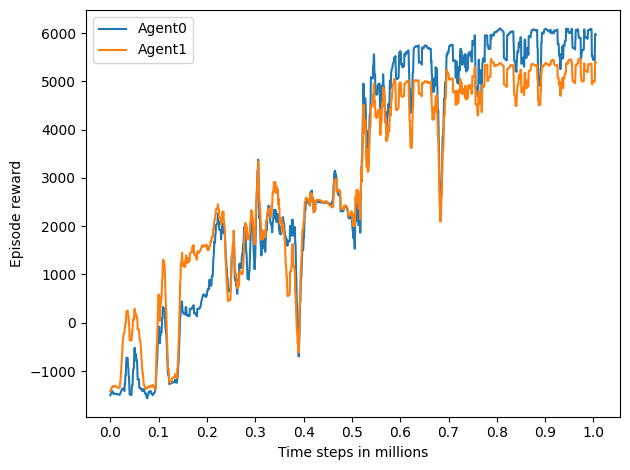

In [39]:
N =10
arr = np.array(maddpg.evaluation_rewards_history)

average_reward = arr.sum(axis=1) / 2
agent0_reward = arr[:,0]
agent1_reward = arr[:,1]
smooth_average_reward = np.convolve(average_reward, np.ones((N))/N, mode='valid')
smooth_agent0_reward = np.convolve(agent0_reward, np.ones((N))/N, mode='valid')
smooth_agent1_reward = np.convolve(agent1_reward, np.ones((N))/N, mode='valid')
print(arr.shape)

#plt.plot(smooth_average_reward)
plt.plot(smooth_agent0_reward)
plt.plot(smooth_agent1_reward)
plt.legend(["Agent0", "Agent1"])
plt.xticks(np.arange(0, 1517, step=150),  labels=[str((0.1)*i)[:3] for i in range(11)])
plt.xlabel("Time steps in millions")
plt.ylabel("Episode reward")
plt.tight_layout()

In [3]:
#Watch policy perform
env = gym.make('pressureplate-custom-2p-0')
obs, _ = env.reset()
dones = [False, False]
import torch


max_episode_length = 100
episode_rewards = np.zeros((2,))
for i in range(max_episode_length):
    if all(dones):
        dones = [False, False]
        print("we are doneee")
        break
    env.render()
    sleep(0.5)

    acts = maddpg.acts(obs)
    nobs, rwds, dones, _ = env.step(acts)
    episode_rewards += np.array(rwds)
    obs = nobs
print(episode_rewards)

/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array 

KeyboardInterrupt: 

In [1]:
import gym
import __init__
import time
import numpy as np
from MADDPGV2.maddpg import MADDPG
from MADDPGV2 import gradient_estimators
from MADDPGV2.buffer import ReplayBuffer
from time import sleep, time
import random


env = gym.make('pressureplate-custom-2p-4')
env.reset()
env.render()

/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-linear-1p-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-custom-2p-0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-custom-2p-1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mert/miniconda3/envs/pressure/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment pressureplate-custom-2p-2 already in registry.
  logger.warn(f"Overriding environm

True